In [1]:
# load packages
import itertools
import json
import math
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler

from model_generator_timeseries import timeseries_model

warnings.filterwarnings('ignore')
% matplotlib inline

### Train estimator of final layer
Once each model of the first layer has been trained and produced the out-of-samples predictions for the hourly secondary band price, the final estiamtor is trained and tested using the same logic.

The inputs for this final model are the out-of-samples predictions together with meta-data of the samples (i.e. time-dependent features of the samples like hour of the day of type of the day).

The model is a two steps simple linear regression. In the first step, a linear regression is fitted with Lasso (*L1*) regularization; those features whose coefficient is non-zero are kept and fed as input for the final linear regression used to predict. However, this time a Ridge (*L2*) regularization is applied. 

### Load predictions from models

In [2]:
# load and rename predictions for models of the first layer
lgbm_df = pd.read_json(
    'predictions/lgbm_predictions.json', 
    orient='records'
)[['y_true', 'y_pred']].rename(columns={'y_pred':'lgbm', 'y_true':'band'})

rf_df = pd.read_json(
    'predictions/rf_predictions.json', 
    orient='records'
)[['y_pred']].rename(columns={'y_pred':'rf'})

knn_df = pd.read_json(
    'predictions/knn_predictions.json', 
    orient='records'
)[['y_pred']].rename(columns={'y_pred':'knn'})

# combine all dfs
stack_df = lgbm_df.merge(pd.concat([knn_df, rf_df], axis=1), how='left', left_index=True, right_index=True)
stack_df.index.name = 'date_hour'

In [3]:
# create features from meta-data (hour and day)
stack_df['hour'] = stack_df.index.hour

weekday_dict = {
    0:'L', 1:'M', 2:'X', 3:'J', 4:'V', 5:'S', 6:'D' 
}

stack_df['date'] = pd.to_datetime(stack_df.index.date)
stack_df['weekday'] = pd.to_datetime(stack_df['date']).dt.dayofweek
stack_df.replace({'weekday':weekday_dict}, inplace=True)

for feature in ['hour', 'weekday']:
    stack_df[
        pd.get_dummies(stack_df[feature], drop_first=True).columns.tolist()
    ] = pd.get_dummies(stack_df[feature], drop_first=True)

# create list of features
features_stack_list = [ 
    element for element in stack_df.columns.tolist() 
    if element not in ['band', 'hour', 'date', 'weekday']
]

### Train stack model
Pipeline of the stacked model:
* Scale features to $\mu=0$, $\sigma=1$
* Select features from Lasso regression with $\lambda=1$
* Ridge regression with $\lambda=200$

The period to estimate starts on 2016-03-01, but the training set goes from 2016-01-31 to 2017-04-30. This means that the first prediciton is generated using around 30 days of out-of-samples predicitons from the models of the first layer. 

In [4]:
# create pipeline
pipeline_stack = make_pipeline(
    StandardScaler(), 
    SelectFromModel(Lasso(alpha=1, random_state=0)),
    Ridge(alpha=200, random_state=0)
)

# initialise timeseries_model class to train and test
stack_model_no_rolling = timeseries_model(
    stack_df, features_stack_list, 'band', '2016-01-31', '2017-04-30', 
    30, pipeline_stack, '2016-03-01', rolling=False
)
# call to cv_scores method in order to get the final predictions
stack_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Acting on fold 50
Acting on fold 60
Acting on fold 70
Acting on fold 80
Acting on fold 90
Acting on fold 100
Acting on fold 110
Acting on fold 120
Acting on fold 130
Acting on fold 140
Acting on fold 150
Acting on fold 160
Acting on fold 170
Acting on fold 180
Acting on fold 190
Acting on fold 200
Acting on fold 210
Acting on fold 220
Acting on fold 230
Acting on fold 240
Acting on fold 250
Acting on fold 260
Acting on fold 270
Acting on fold 280
Acting on fold 290
Acting on fold 300
Acting on fold 310
Acting on fold 320
Acting on fold 330
Acting on fold 340
Acting on fold 350
Acting on fold 360
Acting on fold 370
Acting on fold 380
Acting on fold 390
Acting on fold 400
Acting on fold 410
Acting on fold 420
Mean absolute error: 3.8137 +- 5.0702
Mean squared error: 33.6463 +- 160.8245


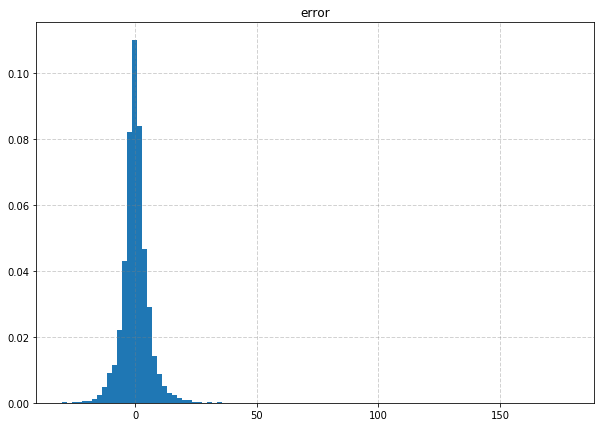

In [5]:
stack_model_no_rolling.plot_histogram_error()

In [6]:
stack_model_no_rolling.get_feature_importance()

                   0
intercept  15.109676
lgbm        6.024351
knn         2.807546


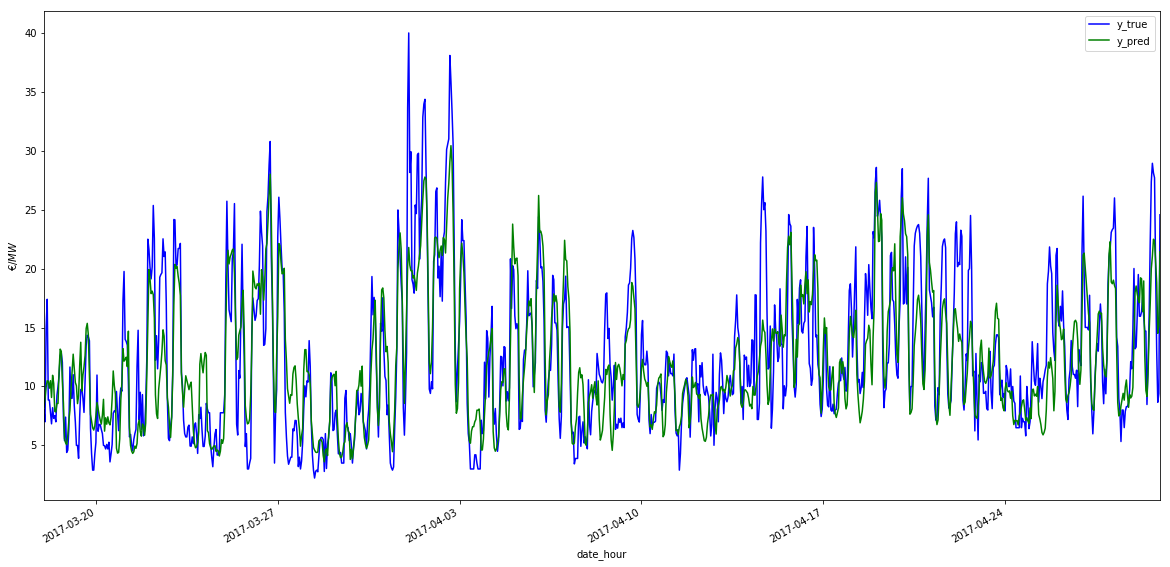

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
stack_model_no_rolling.result_df[['y_true', 'y_pred']].iloc[-1055:-24].plot(
    color=['blue', 'green'],
    ax=ax
)
ax.set_ylabel('$€/MW$');

### Residuals of stack model
The common error metric for a ML model is represented as follows:
$$S_{t} = \widehat{S}_{t} + \sigma_{t}$$

Rearranging the former equation, it can also expressed:
$$\frac{S_{t}}{\widehat{S}_{t}} = \left(1 + \frac{\sigma_{t}}{\widehat{S}_{t}}\right)$$

Where the right hand size can be renamed as a random variable $Y_{t}$, and applying logarithm to both sides:

$$Z_{t} = Ln( Y_{t} )$$

$$Z_{t} = Ln\left (\frac{S_{t}}{\widehat{S}_{t}}\right )$$

The purpose of this subsection is to show that $Z_{t}$ -the residuals- can be approximate to a normal random variable $\epsilon$
$$Z_{t} = \epsilon _{t}$$


In [8]:
# obtain residuals
Y_log = np.log1p(stack_model_no_rolling.result_df['y_true'])
Y_pred_log = np.log1p(stack_model_no_rolling.result_df['y_pred'])
residuals_log = pd.DataFrame(
    {'log_res':Y_log - Y_pred_log}, 
    index=stack_model_no_rolling.result_df.index
)
residuals_log.index.name = 'date_hour'
residuals_log.loc[:, 'hour'] = residuals_log.index.hour
residuals_log.loc[:, 'date'] = residuals_log.index.date

# residuals split by date and hour
residuals_log_date_hour = residuals_log.groupby(
    ['date', 'hour']
)[['log_res']].sum().unstack(-1)['log_res']

An important key of the timeseries modelling is to prove that erros are uncorrelated, which leads to a good efficiency of the estimator. When residuals are correlated, it is called *Serial correlation*. In this particular case, the positive serial correlation could might be happened, i.e. when the residuals in one time period are correlated with errors in following time periods. 

The next heatmap representing the correlation between hours residuals helps to show that errors are uncorrelated across hours of the day. The upper and lower traingle matrices show low correlation, around 0.15 and 0.30 of Pearson's coefficient. However, in the nearby of the main diagonal, the correlation increases, but this is not a main problem, since the correlation is due to the fact that in the secondary band market prices from one hour to another are highly correlated. 

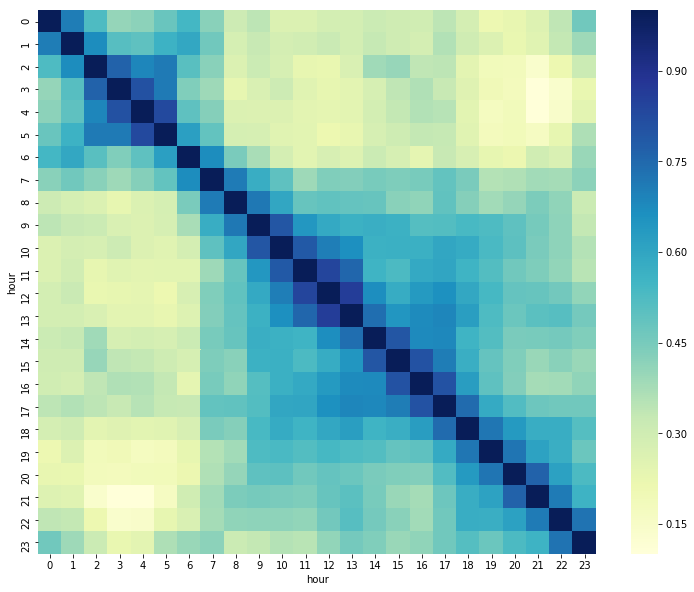

In [9]:
fig, ax = plt.subplots(figsize=(12.5,10))
sns.heatmap(residuals_log_date_hour.corr(), ax=ax, cmap='YlGnBu');

In [10]:
# compute daily and hourly standard deviation of out-of-sample residuals
date_index = pd.date_range(start='2016-03-01', end='2017-04-30', freq='D')
daily_std_list = list()
hourly_std_list = list()
for i in range(len(date_index)):
    
    # daily std
    train_period = date_index.date[:i+1]
    daily_std = residuals_log[
        residuals_log['date'].isin(train_period)
    ]['log_res'].std()
    daily_std_list.append(daily_std)
    
    # hourly std
    hourly_std = residuals_log[
        residuals_log['date'].isin(train_period)
    ].groupby('hour')[['log_res']].std().rename(columns={'log_res':train_period[i]})
    hourly_std_list.append(hourly_std)
    
daily_std_df = pd.DataFrame({'std':daily_std_list}, index=date_index)
hourly_std_df = pd.concat(hourly_std_list, axis=1)
hourly_std_df.columns = pd.to_datetime(hourly_std_df.columns)

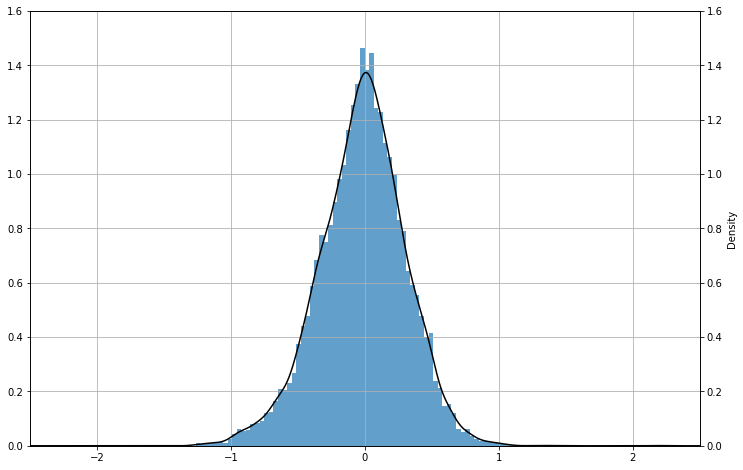

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
residuals_log['log_res'].hist(ax=ax, bins=int(np.sqrt(len(residuals_log))), alpha=0.7, normed=True)
ax.set_xlim([-2.5,2.5])
ax.set_ylim([0, 1.6])
ax2 = ax.twinx()
residuals_log['log_res'].plot(kind='kde', color='black', ax=ax2, lw=1.5, legend=False)
ax2.set_ylim([0, 1.6])
nu, sigma = np.mean(residuals_log['log_res']), np.std(residuals_log['log_res']);

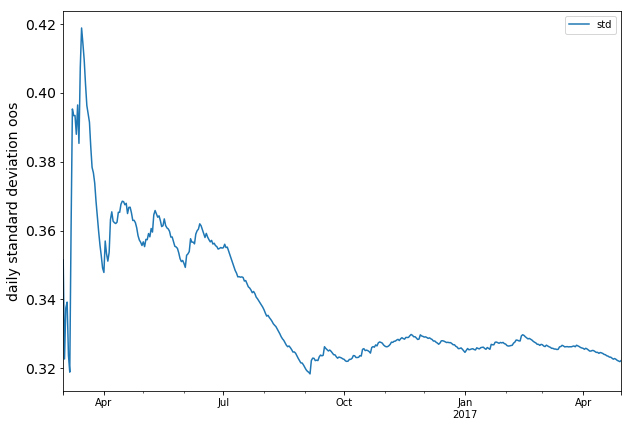

In [12]:
# standard deviation of the residuals out-of-samples until a given date
fig, ax = plt.subplots(1,1, figsize=(10,7))
daily_std_df.plot(ax=ax)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylabel('daily standard deviation oos', size=14);

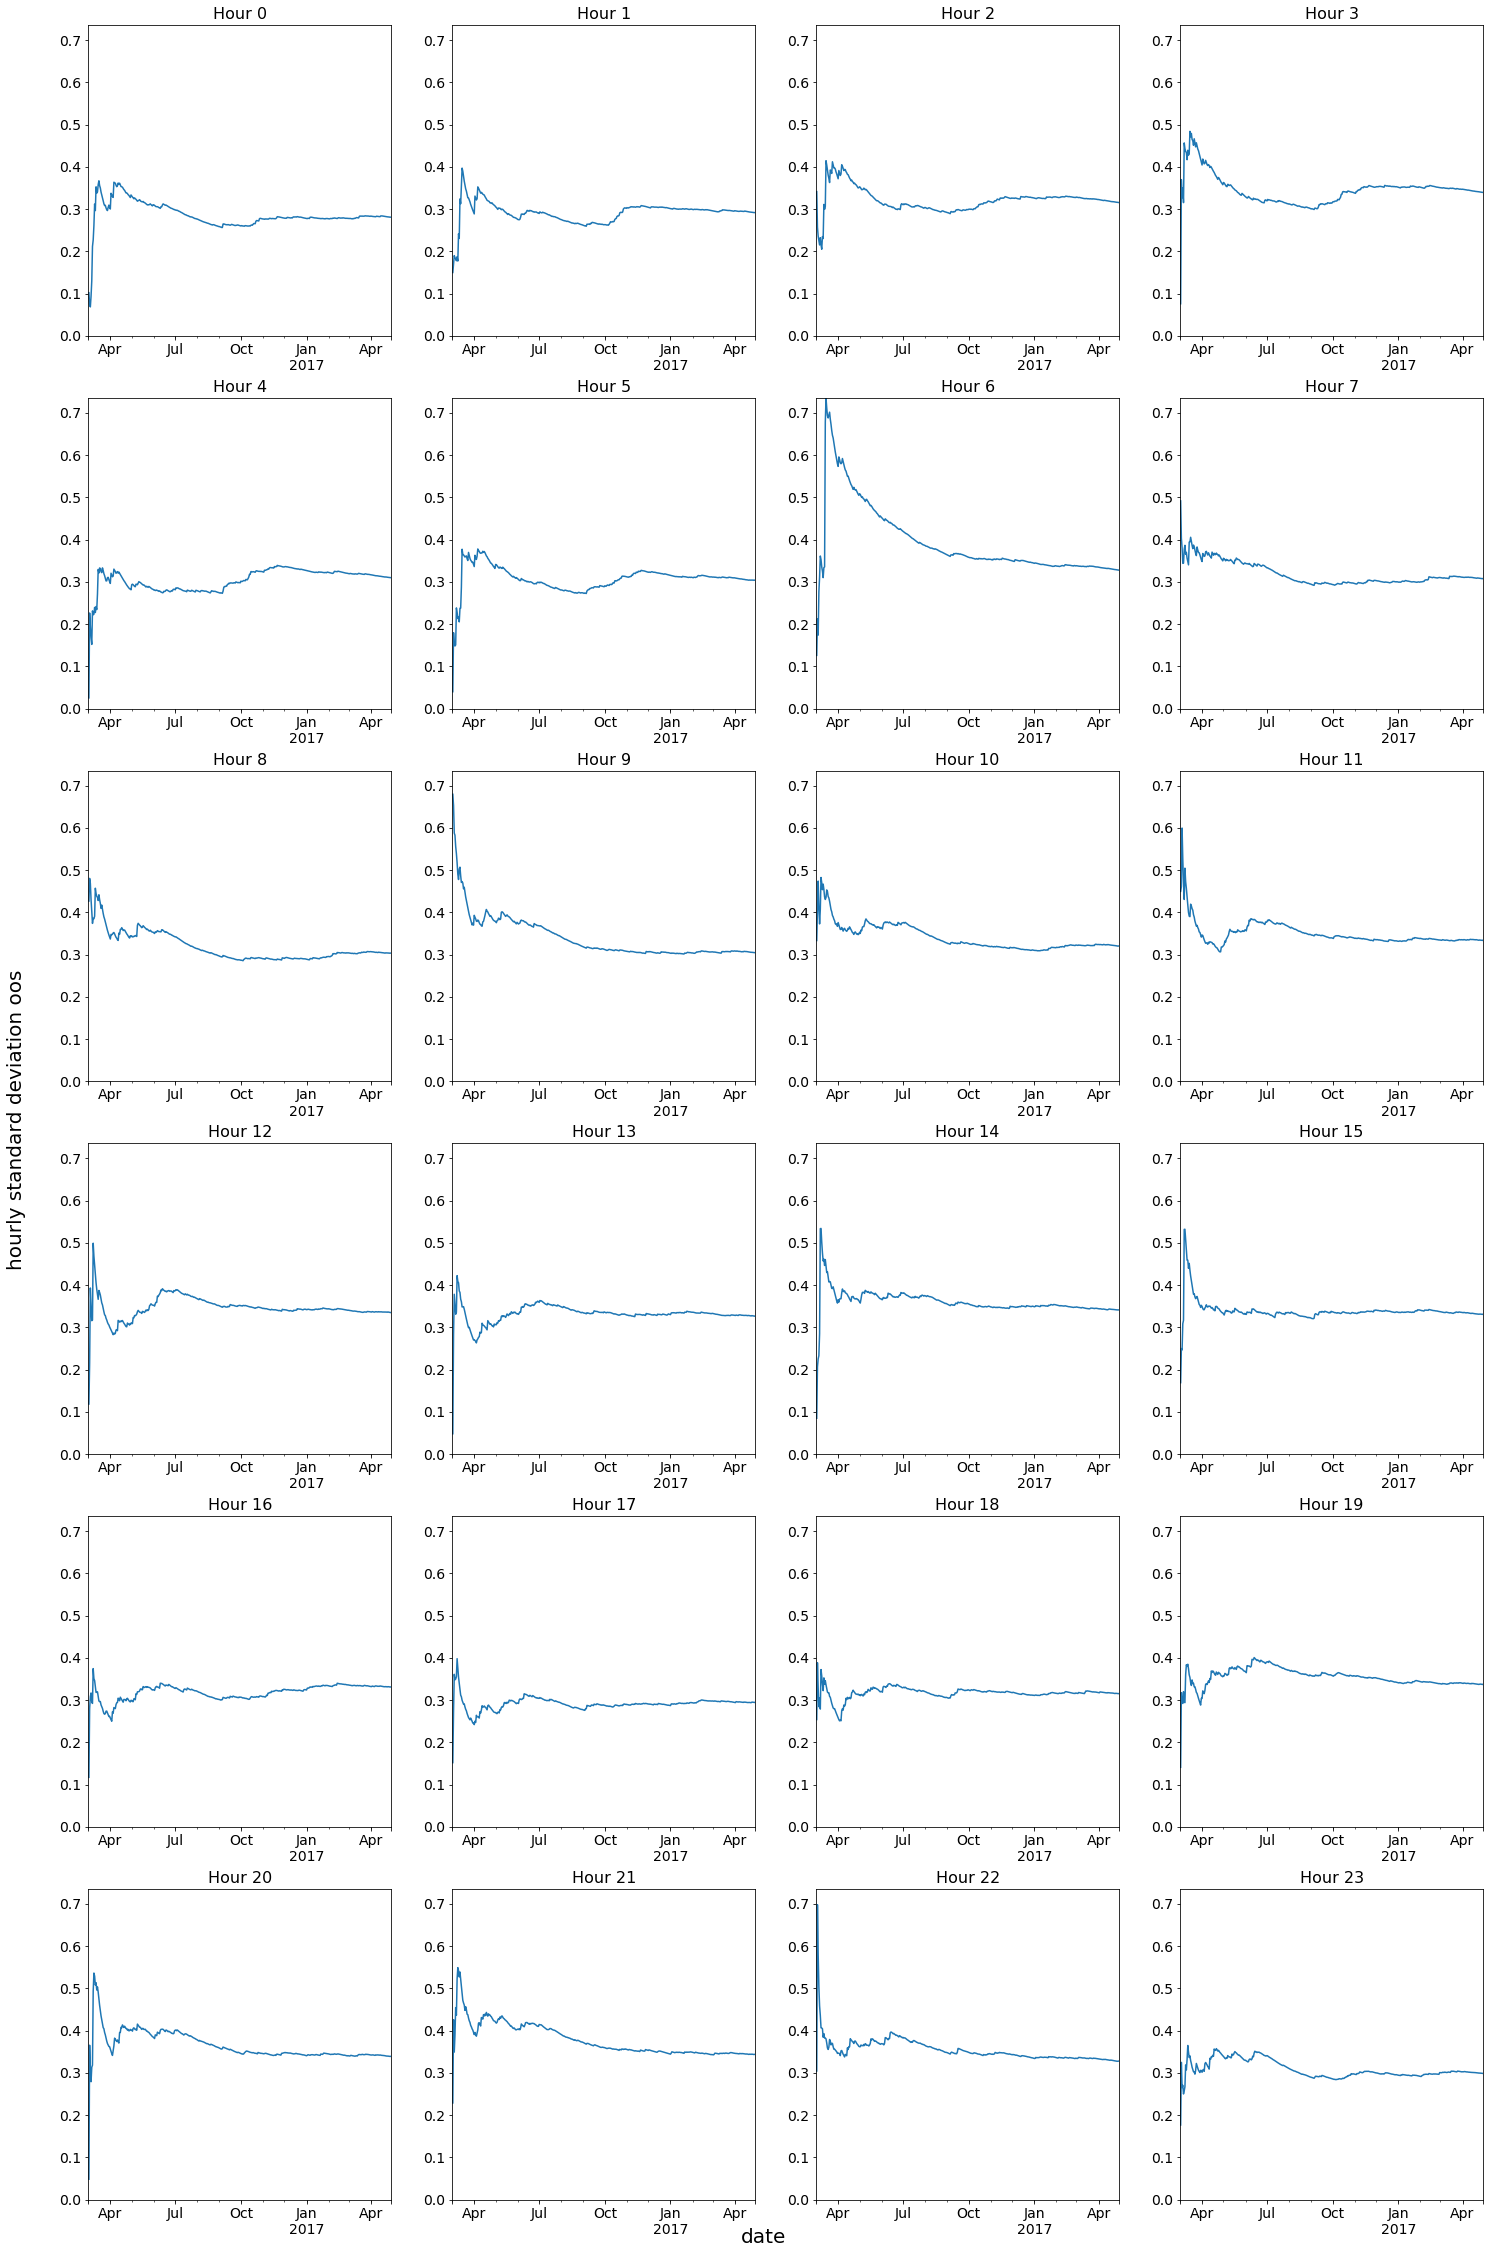

In [13]:
fig, ax = plt.subplots(6,4, figsize=(25,40))
max_std = hourly_std_df.max().max()
for hour, (ax0, ax1) in enumerate(itertools.product(range(6), range(4))):
    hourly_std_df.loc[hour].plot(ax=ax[ax0, ax1])
    ax[ax0, ax1].set_title('Hour ' + str(hour), size=16)
    ax[ax0, ax1].set_ylim([0, max_std])
    ax[ax0, ax1].yaxis.set_tick_params(labelsize=14)
    ax[ax0, ax1].xaxis.set_tick_params(labelsize=14)
fig.text(0.08, 0.5, 'hourly standard deviation oos', va='center', rotation='vertical', size=20)
fig.text(0.5, 0.11, 'date', ha='center', size=20);

In [14]:
# evolution of standard deviation of the in-sample residuals
# this will be used as volatility for the american option
days_length = len(stack_model_no_rolling.fitted_residuals_std)
date_range_fitted_residuals_std = pd.date_range(
    start='2016-03-01', periods=days_length, freq='D'
)
fitted_residuals_std = pd.DataFrame(
    stack_model_no_rolling.fitted_residuals_std, 
    index=date_range_fitted_residuals_std, 
    columns=['residuals_std']
)

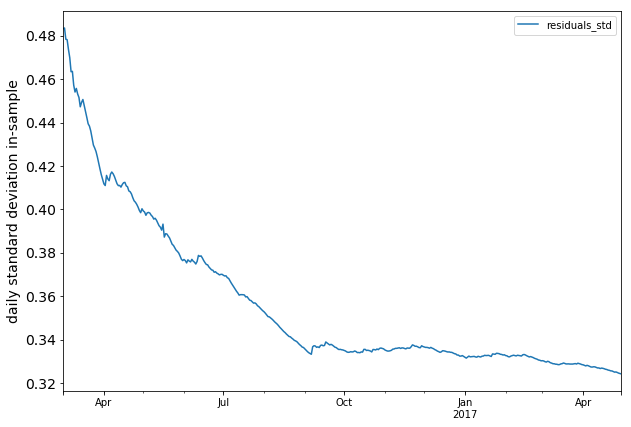

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
fitted_residuals_std.plot(ax=ax)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_ylabel('daily standard deviation in-sample', size=14);

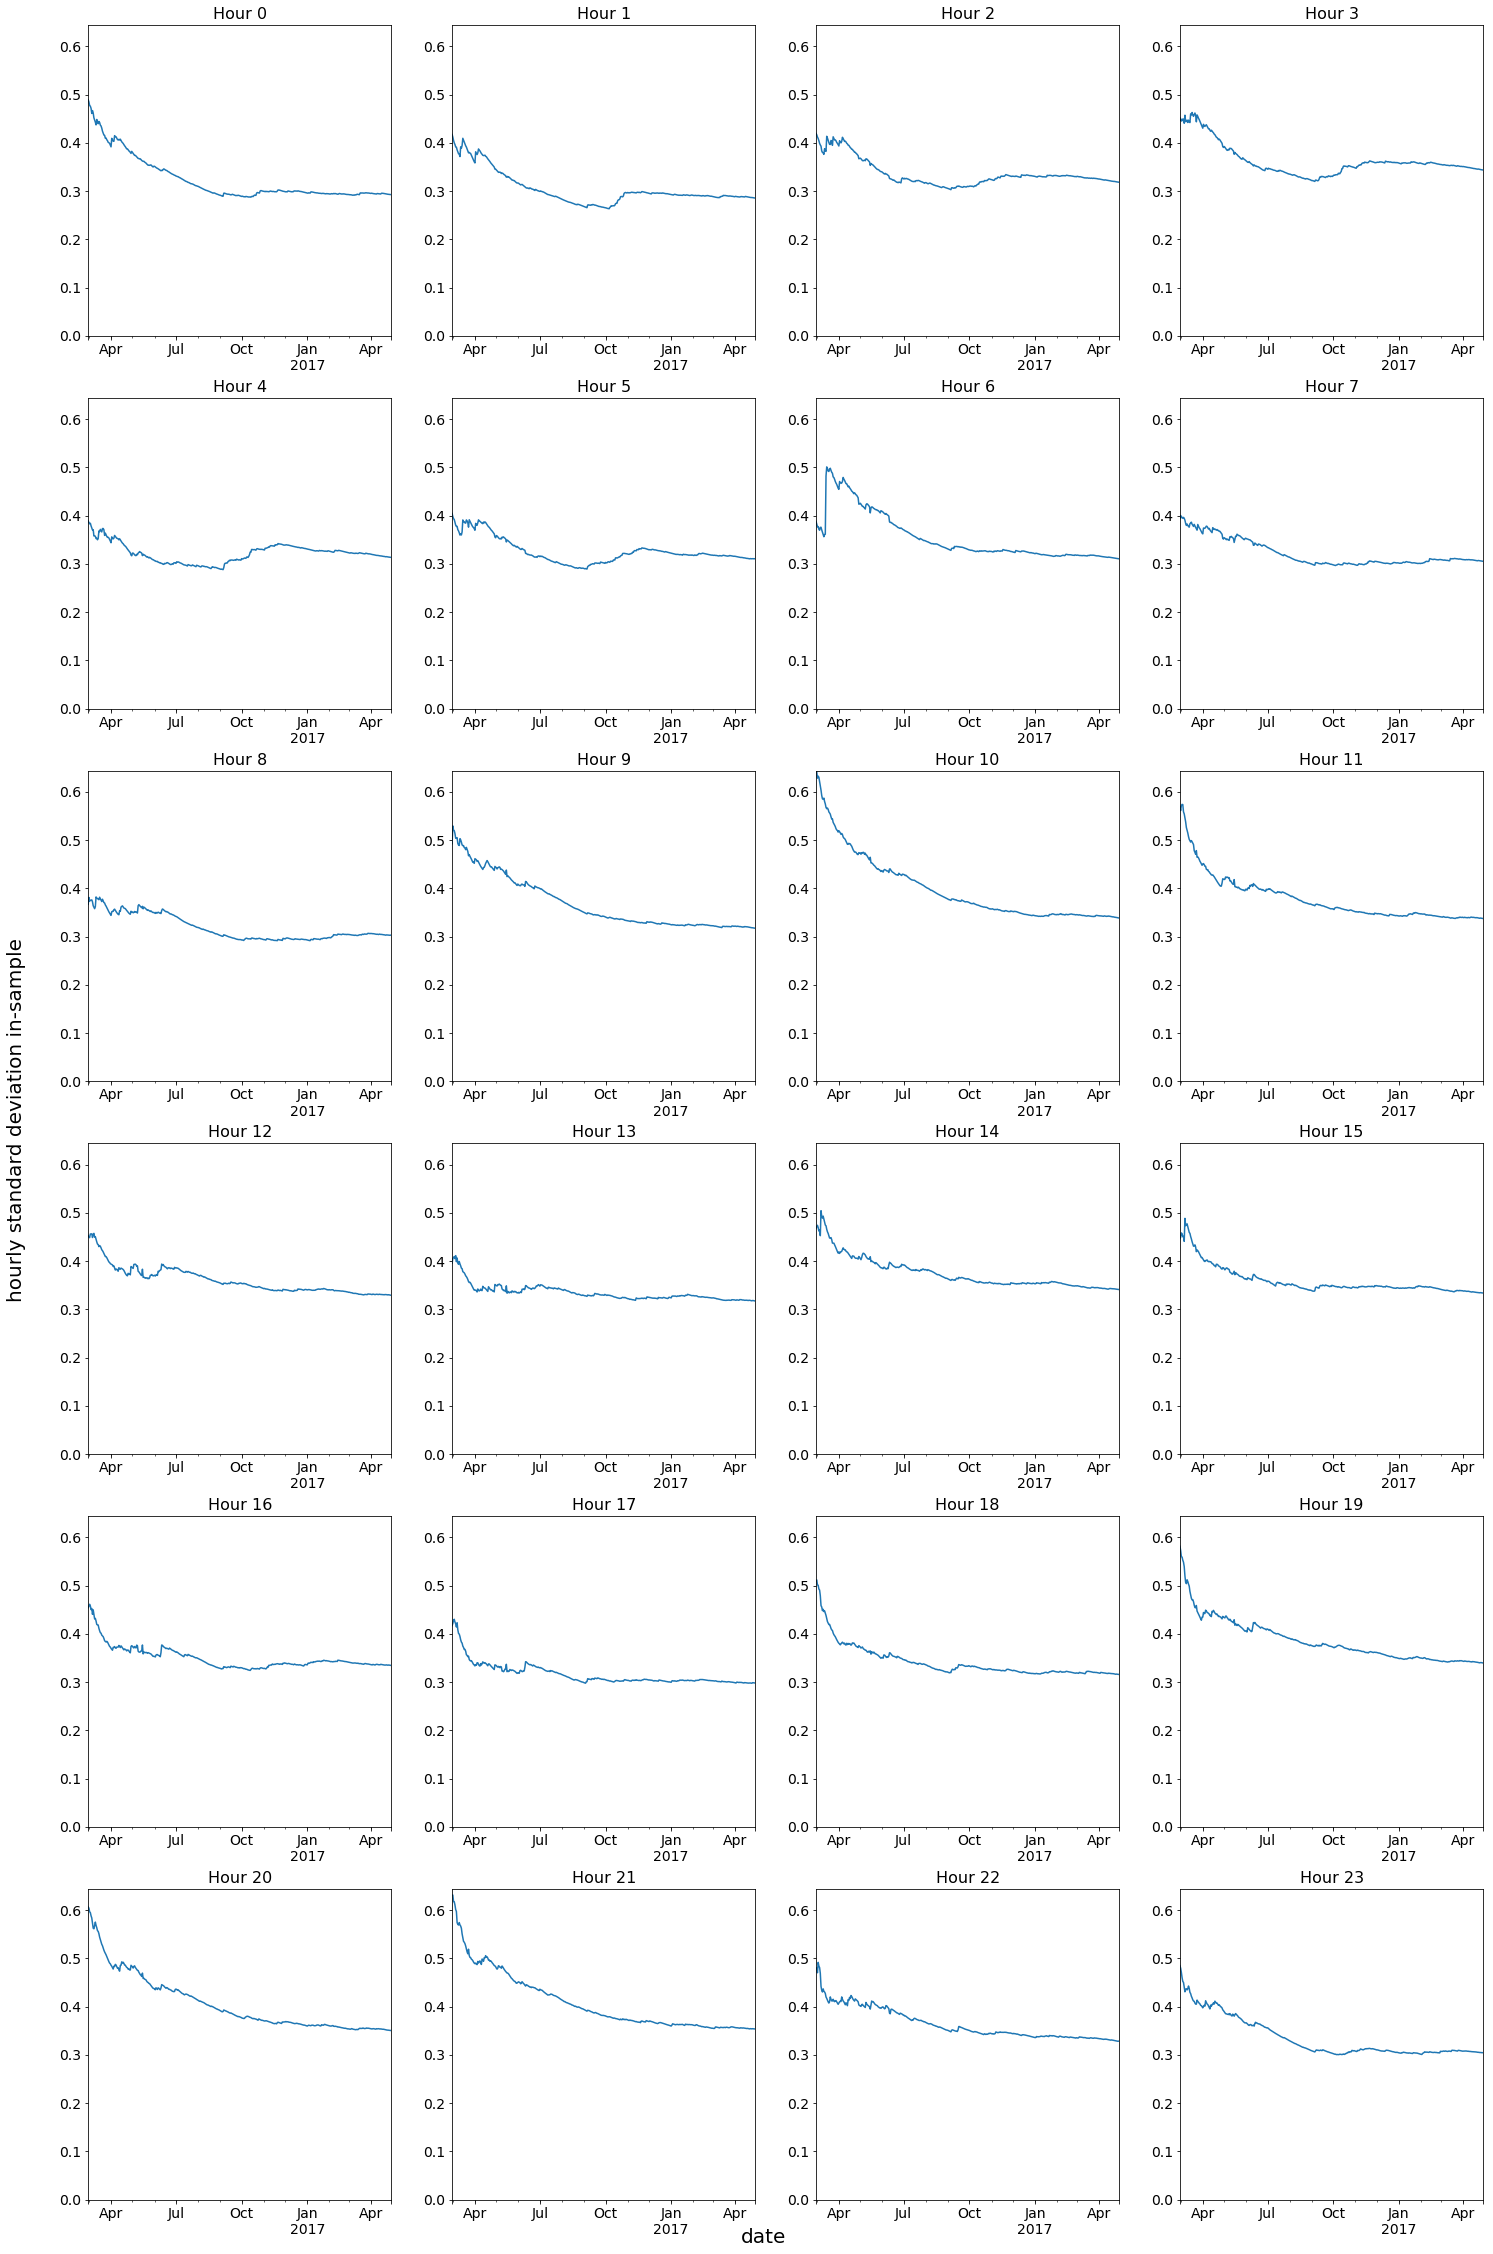

In [16]:
fig, ax = plt.subplots(6,4, figsize=(25,40))
max_std = stack_model_no_rolling.hourly_residuals.max().max()
for hour, (ax0, ax1) in enumerate(itertools.product(range(6), range(4))):
    stack_model_no_rolling.hourly_residuals.loc[hour].plot(ax=ax[ax0, ax1])
    ax[ax0, ax1].set_title('Hour ' + str(hour), size=16)
    ax[ax0, ax1].set_ylim([0, max_std])
    ax[ax0, ax1].yaxis.set_tick_params(labelsize=14)
    ax[ax0, ax1].xaxis.set_tick_params(labelsize=14)
fig.text(0.08, 0.5, 'hourly standard deviation in-sample', va='center', rotation='vertical', size=20)
fig.text(0.5, 0.11, 'date', ha='center', size=20);

$$\epsilon _{t} \sim N(0, \sigma _{xt} ^{2})$$

$$Z_{t} \approx \epsilon _{t}$$

$$S_{t} = f(X_{t})e^{Z_{t}}$$

Export model

In [17]:
with open('saved_models/stack_pipeline.p', 'wb') as f:
    pickle.dump(stack_model_no_rolling.pipeline, f)
    
with open('json/feature_list_band_stack.json', 'w') as f:
    json.dump([str(element) for element in stack_model_no_rolling.features_list], f)

Export residulas

In [18]:
stack_model_no_rolling.result_df.to_json('json/results_stack.json', orient='index', date_format='iso')
residuals_log.to_json('json/residuals_log_stack.json', orient='index', date_format='iso')
daily_std_df.to_json('json/daily_std.json', orient='index', date_format='iso')
fitted_residuals_std.to_json('json/fitted_std_df.json', orient='index', date_format='iso')
stack_model_no_rolling.hourly_residuals.to_json('json/hourly_residuals_in_sample.json', orient='index', date_format='iso')